In [190]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import datetime
import os
import gmaps
import json
from scipy.stats import linregress

locations_df = os.path.join("Resources", "speed-camera-locations.csv")
locations_df = pd.read_csv(locations_df)
violations_df = os.path.join("Resources", "speed-camera-violations.csv")
violations_df = pd.read_csv(violations_df)
tickets_df = os.path.join("Resources", "tickets_df.csv")
wards_df = os.path.join("Resources", "Ward_Offices.csv")
wards_df = pd.read_csv(wards_df)

In [191]:
locations_df = pd.DataFrame(locations_df)
locations_df = locations_df.dropna(how ="any")
violations_df = pd.DataFrame(violations_df)
violations_df = violations_df.dropna(how ="any")
wards_df = pd.DataFrame(wards_df)
wards_df = wards_df.dropna(how = "any")

In [192]:
#ProPublica dataset '03-'17
tickets_df = pd.read_csv(tickets_df)
keep_col = ['issue_date','violation_location', 'zipcode', 'violation_description', 'total_payments', 'year']
tickets_df = tickets_df[keep_col]
tickets_df.to_csv("newFile.csv", index=False)
tickets_df = tickets_df.dropna(how = "any")
tickets_df

/Users/ericnietzer/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,issue_date,violation_location,zipcode,violation_description,total_payments,year
0,2003-11-01 01:04:00,5500 S WESTERN AVE S,60629,RED LIGHT VIOLATION,90.0,2003
1,2003-11-01 01:35:00,2400 W 55TH STREET E,60632,RED LIGHT VIOLATION,190.0,2003
2,2003-11-01 02:41:00,2400 W 55TH STREET E,62901,RED LIGHT VIOLATION,180.0,2003
3,2003-11-01 05:04:00,2400 W 55TH STREET E,60638,RED LIGHT VIOLATION,90.0,2003
4,2003-11-01 06:40:00,2400 W 55TH STREET E,60632,RED LIGHT VIOLATION,90.0,2003
...,...,...,...,...,...,...
11557492,2016-12-31 23:55:00,4700 S KEDZIE AVE,605011172,RED LIGHT VIOLATION,100.0,2016
11557493,2016-12-31 23:56:00,2800 N CICERO AVENUE,60160,RED LIGHT VIOLATION,100.0,2016
11557494,2016-12-31 23:56:00,2000 W DIVISION,605613913,RED LIGHT VIOLATION,100.0,2016
11557495,2016-12-31 23:57:00,3600 N WESTERN AVENUE,601874971,RED LIGHT VIOLATION,100.0,2016


In [193]:
clean_tickets_df = tickets_df.rename(columns={"issue_date":"ISSUED", "violation_location":"ADDRESS", "violation_description":"VIOLATION", "total_payments":"COST"})
clean_tickets_df.head()

,ISSUED,ADDRESS,zipcode,VIOLATION,COST,year
0,2003-11-01 01:04:00,5500 S WESTERN AVE S,60629,RED LIGHT VIOLATION,90.0,2003
1,2003-11-01 01:35:00,2400 W 55TH STREET E,60632,RED LIGHT VIOLATION,190.0,2003
2,2003-11-01 02:41:00,2400 W 55TH STREET E,62901,RED LIGHT VIOLATION,180.0,2003
3,2003-11-01 05:04:00,2400 W 55TH STREET E,60638,RED LIGHT VIOLATION,90.0,2003
4,2003-11-01 06:40:00,2400 W 55TH STREET E,60632,RED LIGHT VIOLATION,90.0,2003


In [194]:
df = clean_tickets_df[['ADDRESS', 'zipcode','VIOLATION','COST', 'year']]
df.head()

,ADDRESS,zipcode,VIOLATION,COST,year
0,5500 S WESTERN AVE S,60629,RED LIGHT VIOLATION,90.0,2003
1,2400 W 55TH STREET E,60632,RED LIGHT VIOLATION,190.0,2003
2,2400 W 55TH STREET E,62901,RED LIGHT VIOLATION,180.0,2003
3,2400 W 55TH STREET E,60638,RED LIGHT VIOLATION,90.0,2003
4,2400 W 55TH STREET E,60632,RED LIGHT VIOLATION,90.0,2003


In [195]:
clean_tickets_df.columns

Index(['ISSUED', 'ADDRESS', 'zipcode', 'VIOLATION', 'COST', 'year'], dtype='object')

In [196]:
clean_tickets_df['zipcode'].value_counts()

60629          84516
60148          78514
60620          78179
60639          74076
60628          67953
               ...  
604731110.0        1
618263221          1
600312310          1
600613217.0        1
600563340.0        1
Name: zipcode, Length: 991129, dtype: int64

In [197]:
clean_tickets_df['COST'].value_counts()

100.00    4659349
0.00      4024410
200.00     778022
244.00     632903
90.00      514018
           ...   
504.00          1
173.33          1
173.42          1
4.48            1
38.70           1
Name: COST, Length: 26287, dtype: int64

In [198]:
clean_tickets_df['VIOLATION'].value_counts()

RED LIGHT VIOLATION                      6810733
SPEED WARNING                            2277887
SPEED VIOLATION 11+                      1931500
SPEED VIOLATION 6-10                      535057
STAND, PARK, OR OTHER USE OF BUS LANE          1
Name: VIOLATION, dtype: int64

In [199]:
clean_tickets_df['year'] = pd.to_numeric(clean_tickets_df['year'])

In [200]:
vio_cost = clean_tickets_df.groupby("VIOLATION")["COST"].count()
COST = [100.00, 0.00, 200.00, 244.00, 90.00]

In [201]:
tic_cost = pd.DataFrame({
        "Fine" : COST,
    "Violation Count": vio_cost
})
tic_cost.head()

,Fine,Violation Count
VIOLATION,,
RED LIGHT VIOLATION,100.0,6810733
SPEED VIOLATION 11+,0.0,1931500
SPEED VIOLATION 6-10,200.0,535057
SPEED WARNING,244.0,2277887
"STAND, PARK, OR OTHER USE OF BUS LANE",90.0,1


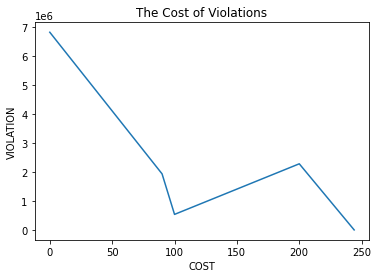

In [215]:
COST = [0.00, 90.00, 100.00, 200.00, 244.00]
Vio_cost = [1, 535057, 1931500, 2277887, 6810733]
VIOLATION = ['RED LIGHT VIOLATION', 'SPEED VIOLATION 11+', 'SPEED VIOLATION 6-10', 'SPEED WARNING', 'STAND,PARK, OR OTHER USE OF BUS LANE']  
plt.plot(COST, vio_cost)
plt.title('The Cost of Violations')
plt.xlabel('COST')
plt.ylabel('VIOLATION')
plt.show()

In [202]:
def to_linear_regress(x, y, weight, arrangement, cmap):
    pearson_r = round(st.pearsonr(x, y)[0],2)
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = f"y = {round(slope,2)}x + {round(intercept, 2)}"
    plt.scatter(x, y, s=weight, c=arrangement, cmap=cmap)
    plt.plot(x,regress_values,"r-")
    print(f"correlation coefficient : {pearson_r}")
    print(f"pvalue: {round(pvalue,2)}")
    return line_eq


In [203]:
def to_annotate(line_eq, x, y):
    plt.annotate(line_eq,(x,y),fontsize=13,color="red")

In [207]:
weight= tic_cost["Violation Count"]*5
arrangement = tic_cost["Violation Count"]
np.arange(len(tic_cost["Violation Count"]))
cmap='tab20' 
line = to_linear_regress(tic_cost["Violation Count"], tic_cost["Fine"], weight, arrangement, cmap)
to_annotate(line, 4, 300000)
plt.xticks(np.arange(1, 10, 1))
plt.xlabel("Fine", fontweight="bold")
plt.ylabel("Violation Count", labelpad=3.5, fontweight="bold") 
plt.title("Violation Type, Cost, and Violation Count", y=1.08, fontweight="bold")
plt.colorbar(label="VIOLATION(Type)", orientation="horizontal") 
plt.rcParams["figure.figsize"] = (12,12)
plt.grid(linewidth=0.3)

NameError: name 'st' is not defined

In [160]:
violations_df.columns

Index(['ADDRESS', 'CAMERA ID', 'VIOLATION DATE', 'VIOLATIONS', 'X COORDINATE',
       'Y COORDINATE', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'Historical Wards 2003-2015', 'Zip Codes', 'Community Areas',
       'Census Tracts', 'Wards'],
      dtype='object')

In [161]:
violations_df.head()

,ADDRESS,CAMERA ID,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,10318 S INDIANAPOLIS,CHI120,2019-11-21T00:00:00.000,87,1.203645e+06,1.837056e+06,41.707577,-87.529848,"{'latitude': '41.70757690291348', 'human_addre...",47.0,21202.0,49.0,705.0,47.0
1,1110 S PULASKI RD,CHI163,2019-11-21T00:00:00.000,7,1.149841e+06,1.894931e+06,41.867603,-87.725383,"{'latitude': '41.86760272243294', 'human_addre...",36.0,21572.0,30.0,98.0,14.0
3,11144 S VINCENNES,CHI023,2019-11-21T00:00:00.000,6,1.166994e+06,1.830711e+06,41.691025,-87.664248,"{'latitude': '41.69102545584918', 'human_addre...",33.0,22212.0,74.0,378.0,42.0
4,11153 S VINCENNES,CHI022,2019-11-21T00:00:00.000,4,1.167029e+06,1.830594e+06,41.690702,-87.664122,"{'latitude': '41.690701951255015', 'human_addr...",45.0,22212.0,74.0,378.0,22.0
5,1117 S PULASKI RD,CHI162,2019-11-21T00:00:00.000,5,1.149923e+06,1.894858e+06,41.867402,-87.725084,"{'latitude': '41.867401834997956', 'human_addr...",36.0,21572.0,30.0,98.0,14.0


In [86]:
vio_loc = pd.DataFrame({
    "Ward Number" : wards,
    "ZIPCODE": ward_num
})
vio_loc.head()

,Ward Number,ZIPCODE
WARD,,
1,1,1
2,3,1
3,4,1
4,8,1
5,10,1


KeyError: "['Speed Cams per Ward', 'LOCATION'] not in index"